<a href="https://colab.research.google.com/github/JBlake26/ECGR4105_IntroToML/blob/main/HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Homework 5**

In [1]:
#drive.mount('/content/drive/')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import torch
import imageio
import torch.optim as optim
import torch.nn as nn
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression 
from sklearn import datasets
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import load_breast_cancer
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from matplotlib.colors import ListedColormap
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms

Problem 1

In our temperature prediction example, let’s change our model to a non-linear system. Consider the following description for our model:

w2 * t_u ** 2 + w1 * t_u + b.

1.a Modify the training loop properly to accommodate this redefinition. 

1.b Use 5000 epochs for your training. Explore different learning rates from 0.1 to 0.0001 (you need four separate trainings). Report your loss for every 500 epochs per training.

1.c Pick the best non-linear model and compare your final best loss against the linear model that we did during the lecture. For this, visualize the non-linear model against the linear model over the input dataset, as we did during the lecture. Is the actual result better or worse than our baseline linear model?

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%matplotlib inline
torch.set_printoptions(edgeitems=2, linewidth=75)

In [4]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

In [5]:
def model(t_u, w2, w1, b):
    return w2 * t_u**2 + w1 * t_u + b

In [6]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

In [7]:
w2 = torch.ones(())
w1 = torch.ones(())
b = torch.zeros(())

t_p = model(t_u, w2, w1, b)
t_p

tensor([1310.1901, 3180.7100, 3445.4399, 6789.5103, 3225.9900, 2440.1101,
        1183.1101,  497.0399, 2390.9600, 3708.5601, 4746.9600])

In [8]:
loss = loss_fn(t_p, t_c)
loss

tensor(11709471.)

In [9]:
x = torch.ones(())
y = torch.ones(3,1)
z = torch.ones(1,3)
a = torch.ones(2, 1, 1)
print(f"shapes: x: {x.shape}, y: {y.shape}")
print(f"        z: {z.shape}, a: {a.shape}")
print("x * y:", (x * y).shape)
print("y * z:", (y * z).shape)
print("y * z * a:", (y * z * a).shape)

shapes: x: torch.Size([]), y: torch.Size([3, 1])
        z: torch.Size([1, 3]), a: torch.Size([2, 1, 1])
x * y: torch.Size([3, 1])
y * z: torch.Size([3, 3])
y * z * a: torch.Size([2, 3, 3])


In [10]:
delta = 0.1

loss_rate_of_change_w = \
    (loss_fn(model(t_u, w2 + delta, w1 + delta, b), t_c) - 
     loss_fn(model(t_u, w2 - delta, w1 - delta, b), t_c)) / (2.0 * delta)

In [11]:
learning_rate = 1e-2

w = (w2+w1) - learning_rate * loss_rate_of_change_w
w

tensor(-235103.4375)

In [12]:
loss_rate_of_change_b = \
    (loss_fn(model(t_u, w2, w1, b + delta), t_c) - 
     loss_fn(model(t_u, w2, w1, b - delta), t_c)) / (2.0 * delta)

b = b - learning_rate * loss_rate_of_change_b
b

tensor(-59.6500)

In [13]:
def dloss_fn(t_p, t_c):
    dsq_diffs = 2 * (t_p - t_c) / t_p.size(0)  # <1>
    return dsq_diffs

In [14]:
def dmodel_dw(t_u, w2, w1, b):
    return t_u

In [15]:
def dmodel_db(t_u, w2, w1, b):
    return 1.0

In [16]:
def grad_fn(t_u, t_c, t_p, w2, w1, b):
    dloss_dtp = dloss_fn(t_p, t_c)
    dloss_dw2 = dloss_dtp * dmodel_dw2(t_u, w2, w1, b)
    dloss_dw1 = dloss_dtp * dmodel_dw1(t_u, w2, w1, b)
    dloss_db = dloss_dtp * dmodel_db(t_u, w2, w1, b)
    return torch.stack([dloss_dw2.sum(), dloss_dw1.sum(), dloss_db.sum()])  # <1>

In [17]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        w, b = params

        t_p = model(t_u, w, b)  # <1>
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b)  # <2>

        params = params - learning_rate * grad

        print('Epoch %d, Loss %f' % (epoch, float(loss))) # <3>
            
    return params

In [18]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c,
                  print_params=True):
    for epoch in range(1, n_epochs + 1):
        w, b = params

        t_p = model(t_u, w, b)  # <1>
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b)  # <2>

        params = params - learning_rate * grad

        if epoch in {1, 2, 3, 10, 11, 99, 100, 4000, 5000}:  # <3>
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            if print_params:
                print('    Params:', params)
                print('    Grad:  ', grad)
        if epoch in {4, 12, 101}:
            print('...')

        if not torch.isfinite(loss).all():
            break  # <3>
            
    return params

In [19]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        if params.grad is not None:  # <1>
            params.grad.zero_()
        
        t_p = model(t_u, *params) 
        loss = loss_fn(t_p, t_c)
        loss.backward()
        
        with torch.no_grad():  # <2>
            params -= learning_rate * params.grad

        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            
    return params

In [20]:
training_loop(
    n_epochs = 100, 
    learning_rate = 1e-2, 
    params = torch.tensor([1.0, 1.0, 0.0], requires_grad=True), 
    t_u = t_u, 
    t_c = t_c)

tensor([nan, nan, nan], requires_grad=True)

In [21]:
training_loop(
    n_epochs = 100, 
    learning_rate = 1e-4, 
    params = torch.tensor([1.0, 1.0, 0.0], requires_grad=True), 
    t_u = t_u, 
    t_c = t_c)

tensor([nan, nan, nan], requires_grad=True)

In [22]:
t_un = 0.1 * t_u

In [23]:
training_loop(
    n_epochs = 100, 
    learning_rate = 1e-2, 
    params = torch.tensor([1.0, 1.0, 0.0], requires_grad=True), 
    t_u = t_un, # <1>
    t_c = t_c)

tensor([nan, nan, nan], requires_grad=True)

In [24]:
params = training_loop(
    n_epochs = 5000, 
    learning_rate = 0.1, 
    params = torch.tensor([1.0, 1.0, 0.0], requires_grad=True), 
    t_u = t_un, 
    t_c = t_c)

params

Epoch 500, Loss nan
Epoch 1000, Loss nan
Epoch 1500, Loss nan
Epoch 2000, Loss nan
Epoch 2500, Loss nan
Epoch 3000, Loss nan
Epoch 3500, Loss nan
Epoch 4000, Loss nan
Epoch 4500, Loss nan
Epoch 5000, Loss nan


tensor([nan, nan, nan], requires_grad=True)

In [25]:
params = training_loop(
    n_epochs = 5000, 
    learning_rate = 0.01, 
    params = torch.tensor([1.0, 1.0, 0.0], requires_grad=True), 
    t_u = t_un, 
    t_c = t_c)

params

Epoch 500, Loss nan
Epoch 1000, Loss nan
Epoch 1500, Loss nan
Epoch 2000, Loss nan
Epoch 2500, Loss nan
Epoch 3000, Loss nan
Epoch 3500, Loss nan
Epoch 4000, Loss nan
Epoch 4500, Loss nan
Epoch 5000, Loss nan


tensor([nan, nan, nan], requires_grad=True)

In [26]:
params = training_loop(
    n_epochs = 5000, 
    learning_rate = 0.001, 
    params = torch.tensor([1.0, 1.0, 0.0], requires_grad=True), 
    t_u = t_un, 
    t_c = t_c)

params

Epoch 500, Loss nan
Epoch 1000, Loss nan
Epoch 1500, Loss nan
Epoch 2000, Loss nan
Epoch 2500, Loss nan
Epoch 3000, Loss nan
Epoch 3500, Loss nan
Epoch 4000, Loss nan
Epoch 4500, Loss nan
Epoch 5000, Loss nan


tensor([nan, nan, nan], requires_grad=True)

In [27]:
params = training_loop(
    n_epochs = 5000, 
    learning_rate = 0.0001, 
    params = torch.tensor([1.0, 1.0, 0.0], requires_grad=True), 
    t_u = t_un, 
    t_c = t_c)

params

Epoch 500, Loss 10.708596
Epoch 1000, Loss 8.642083
Epoch 1500, Loss 7.171005
Epoch 2000, Loss 6.123477
Epoch 2500, Loss 5.377227
Epoch 3000, Loss 4.845285
Epoch 3500, Loss 4.465788
Epoch 4000, Loss 4.194724
Epoch 4500, Loss 4.000802
Epoch 5000, Loss 3.861744


tensor([ 0.5570, -0.8881, -0.8753], requires_grad=True)

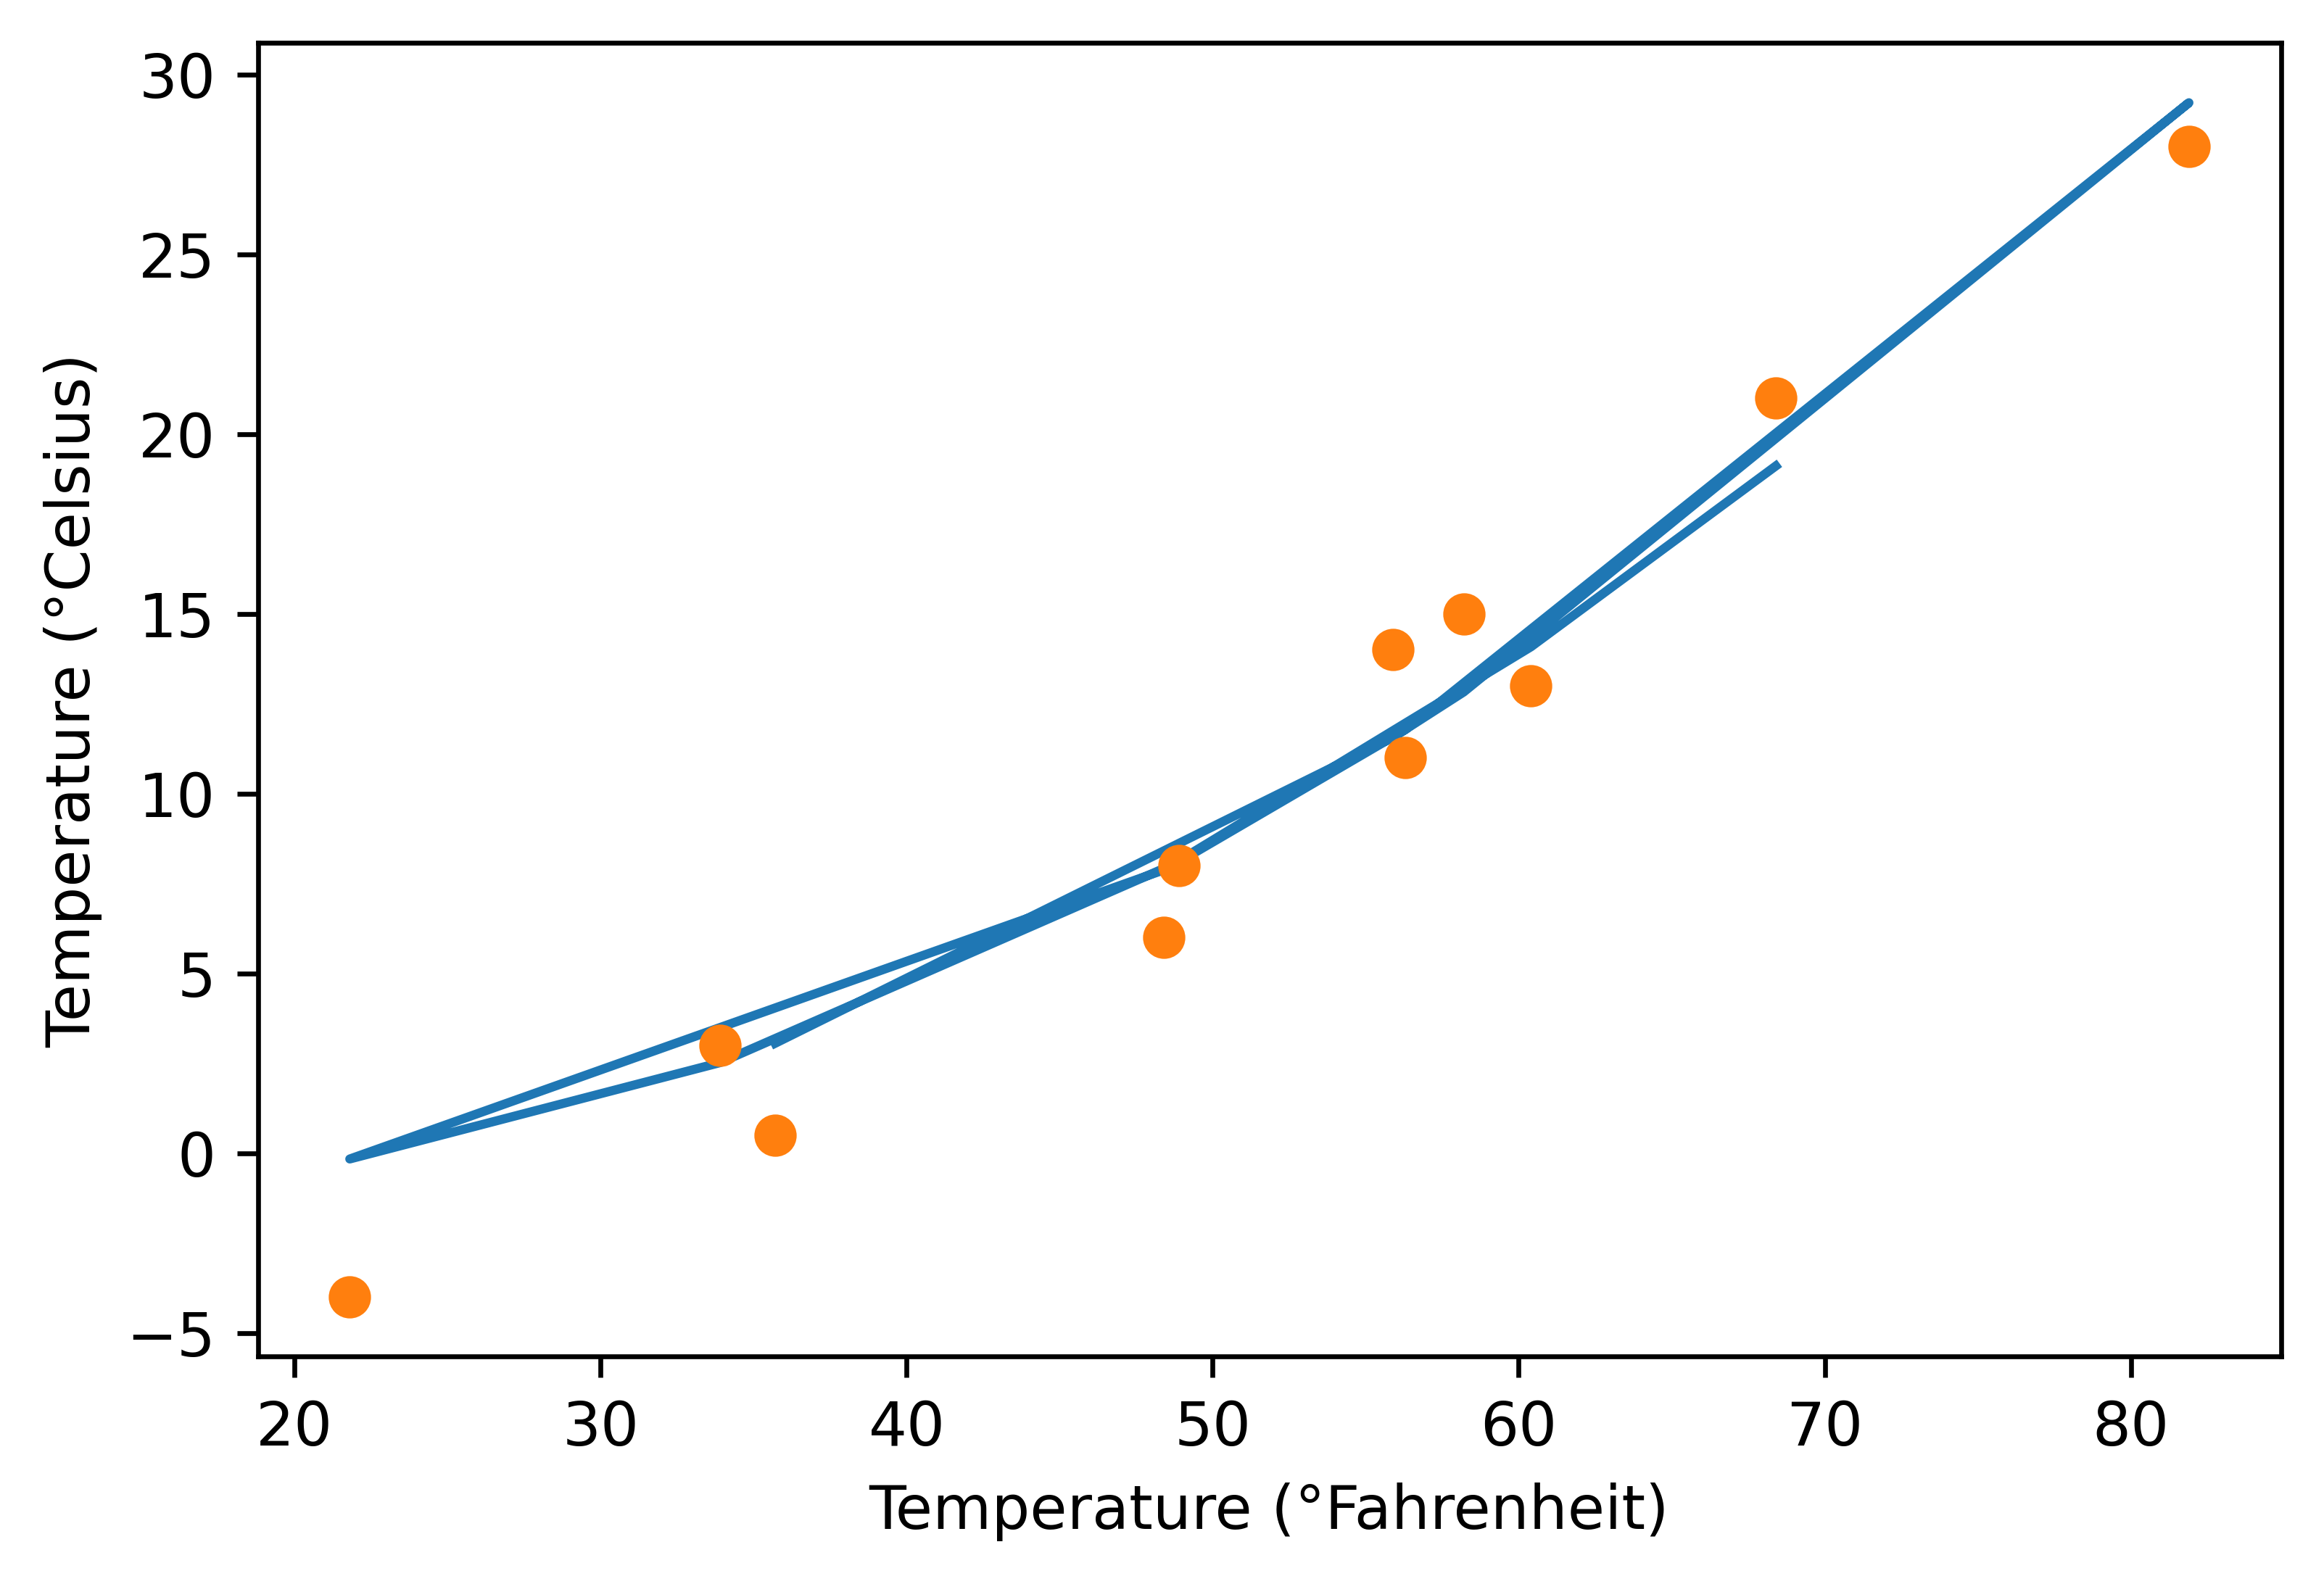

In [28]:
%matplotlib inline
from matplotlib import pyplot as plt

t_p = model(t_un, *params)  # <1>

fig = plt.figure(dpi=600)
plt.xlabel("Temperature (°Fahrenheit)")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_p.detach().numpy()) # <2>
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.savefig("temp_unknown_plot.png", format="png")  # bookskip

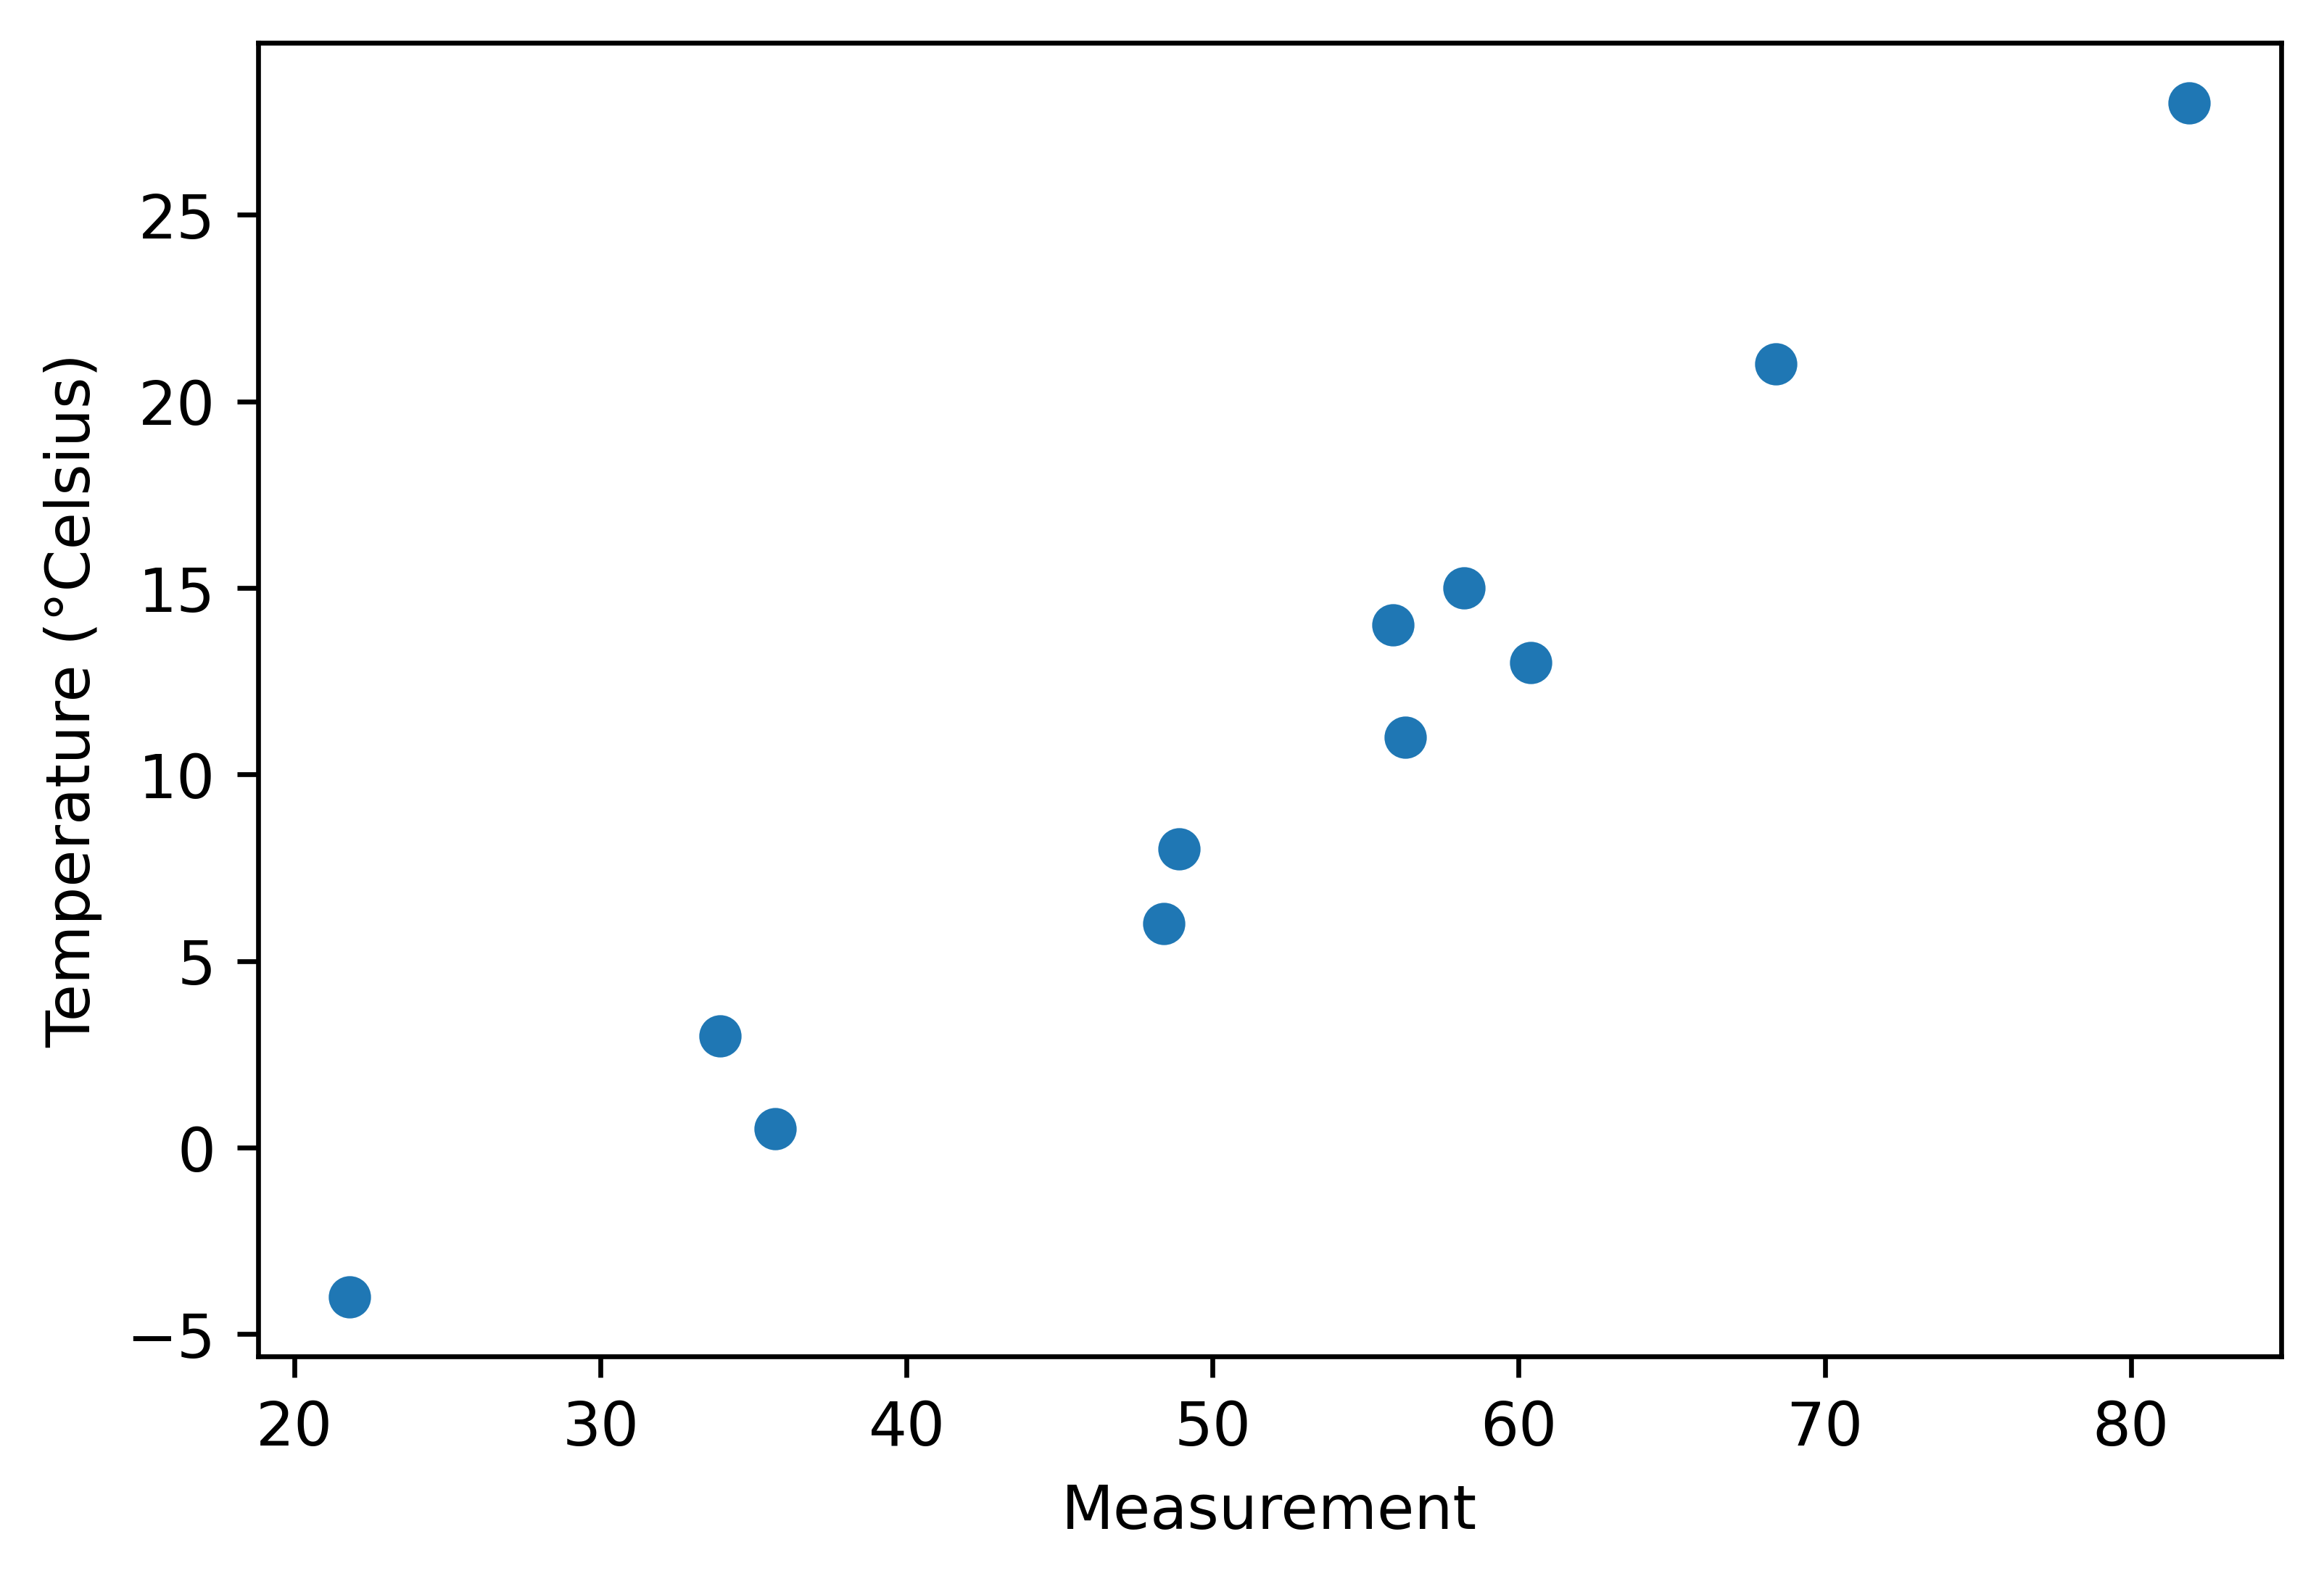

In [29]:
%matplotlib inline
from matplotlib import pyplot as plt

fig = plt.figure(dpi=600)
plt.xlabel("Measurement")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')

plt.savefig("temp_data_plot.png", format="png")

Problem 2

2.a. Develop preprocessing and a training loop to train a linear regression model that predicts housing price based on the following input variables:

area, bedrooms, bathrooms, stories, parking

For this, you need to use the housing dataset. For training and validation use 80% (training) and 20% (validation) split. Identify the best parameters for your linear regression model, based on the above input variables. In this case, you will have six parameters:

U=W5*X5 + W4*X4 + W3*X3 + W2*X2 + W1*X1 + B

2.b Use 5000 epochs for your training. Explore different learning rates from 0.1 to 0.0001 (you need four separate trainings). Report your loss and validation accuracy for every 500 epochs per each training. Pick the best linear model.

Reading the Training Data

In [30]:
housing = pd.DataFrame(pd.read_csv("/content/drive/MyDrive/ECGR 4105 - Intro to Machine Learning/Homework/Housing.csv"))
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [31]:
num_vars = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking', 'price'] 
spectrain = housing[num_vars] 
spectrain.head() 

,area,bedrooms,bathrooms,stories,parking,price
0,7420,4,2,3,2,13300000
1,8960,4,4,4,3,12250000
2,9960,3,2,2,2,12250000
3,7500,4,2,2,3,12215000
4,7420,4,1,2,2,11410000


Price Prediction

In [32]:
t_area = torch.tensor(spectrain['area'])
t_bedrooms = torch.tensor(spectrain['bedrooms'])
t_bathrooms = torch.tensor(spectrain['bathrooms'])
t_stories = torch.tensor(spectrain['stories'])
t_parking = torch.tensor(spectrain['parking'])
t_price = torch.tensor(spectrain['price'])

Normalize

In [33]:

t_areaN = t_area / max(spectrain['area'])
t_bedroomsN = t_bedrooms / max(spectrain['bedrooms'])
t_bathroomsN = t_bathrooms / max(spectrain['bathrooms'])
t_storiesN = t_stories / max(spectrain['stories'])
t_parkingN = t_parking / max(spectrain['parking'])

Define the Model

In [34]:
def model(t_area, t_bedrooms, t_bathrooms, t_stories, t_parking, w1, w2, w3, w4, w5, b):
    return w5*t_parking + w4*t_stories + w3*t_bathrooms + w2*t_bedrooms + w1*t_area + b

Calculate the Loss

In [35]:
def loss_fn(t_p, t_price):
    squared_diffs = (t_p - t_price)**2
    return squared_diffs.mean()

Parameters

In [36]:
params = torch.tensor([1.0,1.0,1.0,1.0,1.0,0.0], requires_grad=True)

In [37]:
params.grad is None

True

In [38]:
loss = loss_fn(model(t_area, t_bedrooms, t_bathrooms, t_stories, t_parking, *params), t_price)
loss.backward()
params.grad

tensor([-5.3383e+10, -2.9247e+07, -1.3220e+07, -1.8557e+07, -7.8404e+06,
        -9.5231e+06])

In [39]:
if params.grad is not None:
    params.grad.zero_()

Define the Training Loop

In [40]:
def training_loop(n_epochs, learning_rate, params, t_area, t_bedrooms, t_bathrooms, t_stories, t_parking, t_price):
    for epoch in range(1, n_epochs + 1):
        if params.grad is not None:  # <1>
            params.grad.zero_()
        
        t_p = model(t_area, t_bedrooms, t_bathrooms, t_stories, t_parking, *params) 
        loss = loss_fn(t_p, t_price)
        loss.backward()
        
        with torch.no_grad():  # <2>
            params -= learning_rate * params.grad

        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            
    return params

Loss When Learning Rate = 0.1

In [41]:
params = training_loop(
    n_epochs = 5000, 
    learning_rate = 0.1, 
    params = torch.tensor([1.0,1.0,1.0,1.0,1.0,0.0], requires_grad=True), # <1> 
    t_area = t_areaN,
    t_bedrooms = t_bedroomsN,
    t_bathrooms = t_bathroomsN,
    t_stories = t_storiesN,
    t_parking = t_parkingN,
    t_price = t_price)

Epoch 500, Loss 1562038501376.000000
Epoch 1000, Loss 1533011427328.000000
Epoch 1500, Loss 1531161870336.000000
Epoch 2000, Loss 1531023589376.000000
Epoch 2500, Loss 1531010482176.000000
Epoch 3000, Loss 1531008778240.000000
Epoch 3500, Loss 1531008516096.000000
Epoch 4000, Loss 1531008516096.000000
Epoch 4500, Loss 1531008516096.000000
Epoch 5000, Loss 1531008516096.000000


Loss When Learning Rate = 0.01

In [42]:
params = training_loop(
    n_epochs = 5000, 
    learning_rate = 0.01, 
    params = torch.tensor([1.0,1.0,1.0,1.0,1.0,0.0], requires_grad=True), # <1> 
    t_area = t_areaN,
    t_bedrooms = t_bedroomsN,
    t_bathrooms = t_bathroomsN,
    t_stories = t_storiesN,
    t_parking = t_parkingN,
    t_price = t_price)

Epoch 500, Loss 2024805761024.000000
Epoch 1000, Loss 1863258734592.000000
Epoch 1500, Loss 1768051179520.000000
Epoch 2000, Loss 1704594898944.000000
Epoch 2500, Loss 1659788853248.000000
Epoch 3000, Loss 1627244199936.000000
Epoch 3500, Loss 1603242295296.000000
Epoch 4000, Loss 1585383211008.000000
Epoch 4500, Loss 1572023042048.000000
Epoch 5000, Loss 1561993281536.000000


Loss When Learning Rate = 0.001

In [43]:
params = training_loop(
    n_epochs = 5000, 
    learning_rate = 0.001, 
    params = torch.tensor([1.0,1.0,1.0,1.0,1.0,0.0], requires_grad=True), # <1> 
    t_area = t_areaN,
    t_bedrooms = t_bedroomsN,
    t_bathrooms = t_bathroomsN,
    t_stories = t_storiesN,
    t_parking = t_parkingN,
    t_price = t_price)

Epoch 500, Loss 3072061341696.000000
Epoch 1000, Loss 2296906776576.000000
Epoch 1500, Loss 2232370855936.000000
Epoch 2000, Loss 2193781817344.000000
Epoch 2500, Loss 2159230582784.000000
Epoch 3000, Loss 2127642755072.000000
Epoch 3500, Loss 2098654216192.000000
Epoch 4000, Loss 2071965073408.000000
Epoch 4500, Loss 2047316459520.000000
Epoch 5000, Loss 2024483717120.000000


Loss When Learning Rate = 0.0001

In [44]:
params = training_loop(
    n_epochs = 5000, 
    learning_rate = 0.0001, 
    params = torch.tensor([1.0,1.0,1.0,1.0,1.0,0.0], requires_grad=True), # <1> 
    t_area = t_areaN,
    t_bedrooms = t_bedroomsN,
    t_bathrooms = t_bathroomsN,
    t_stories = t_storiesN,
    t_parking = t_parkingN,
    t_price = t_price)

Epoch 500, Loss 19251110871040.000000
Epoch 1000, Loss 14310294159360.000000
Epoch 1500, Loss 10812095725568.000000
Epoch 2000, Loss 8334880538624.000000
Epoch 2500, Loss 6580248510464.000000
Epoch 3000, Loss 5337011716096.000000
Epoch 3500, Loss 4455729725440.000000
Epoch 4000, Loss 3830616424448.000000
Epoch 4500, Loss 3386812137472.000000
Epoch 5000, Loss 3071338610688.000000


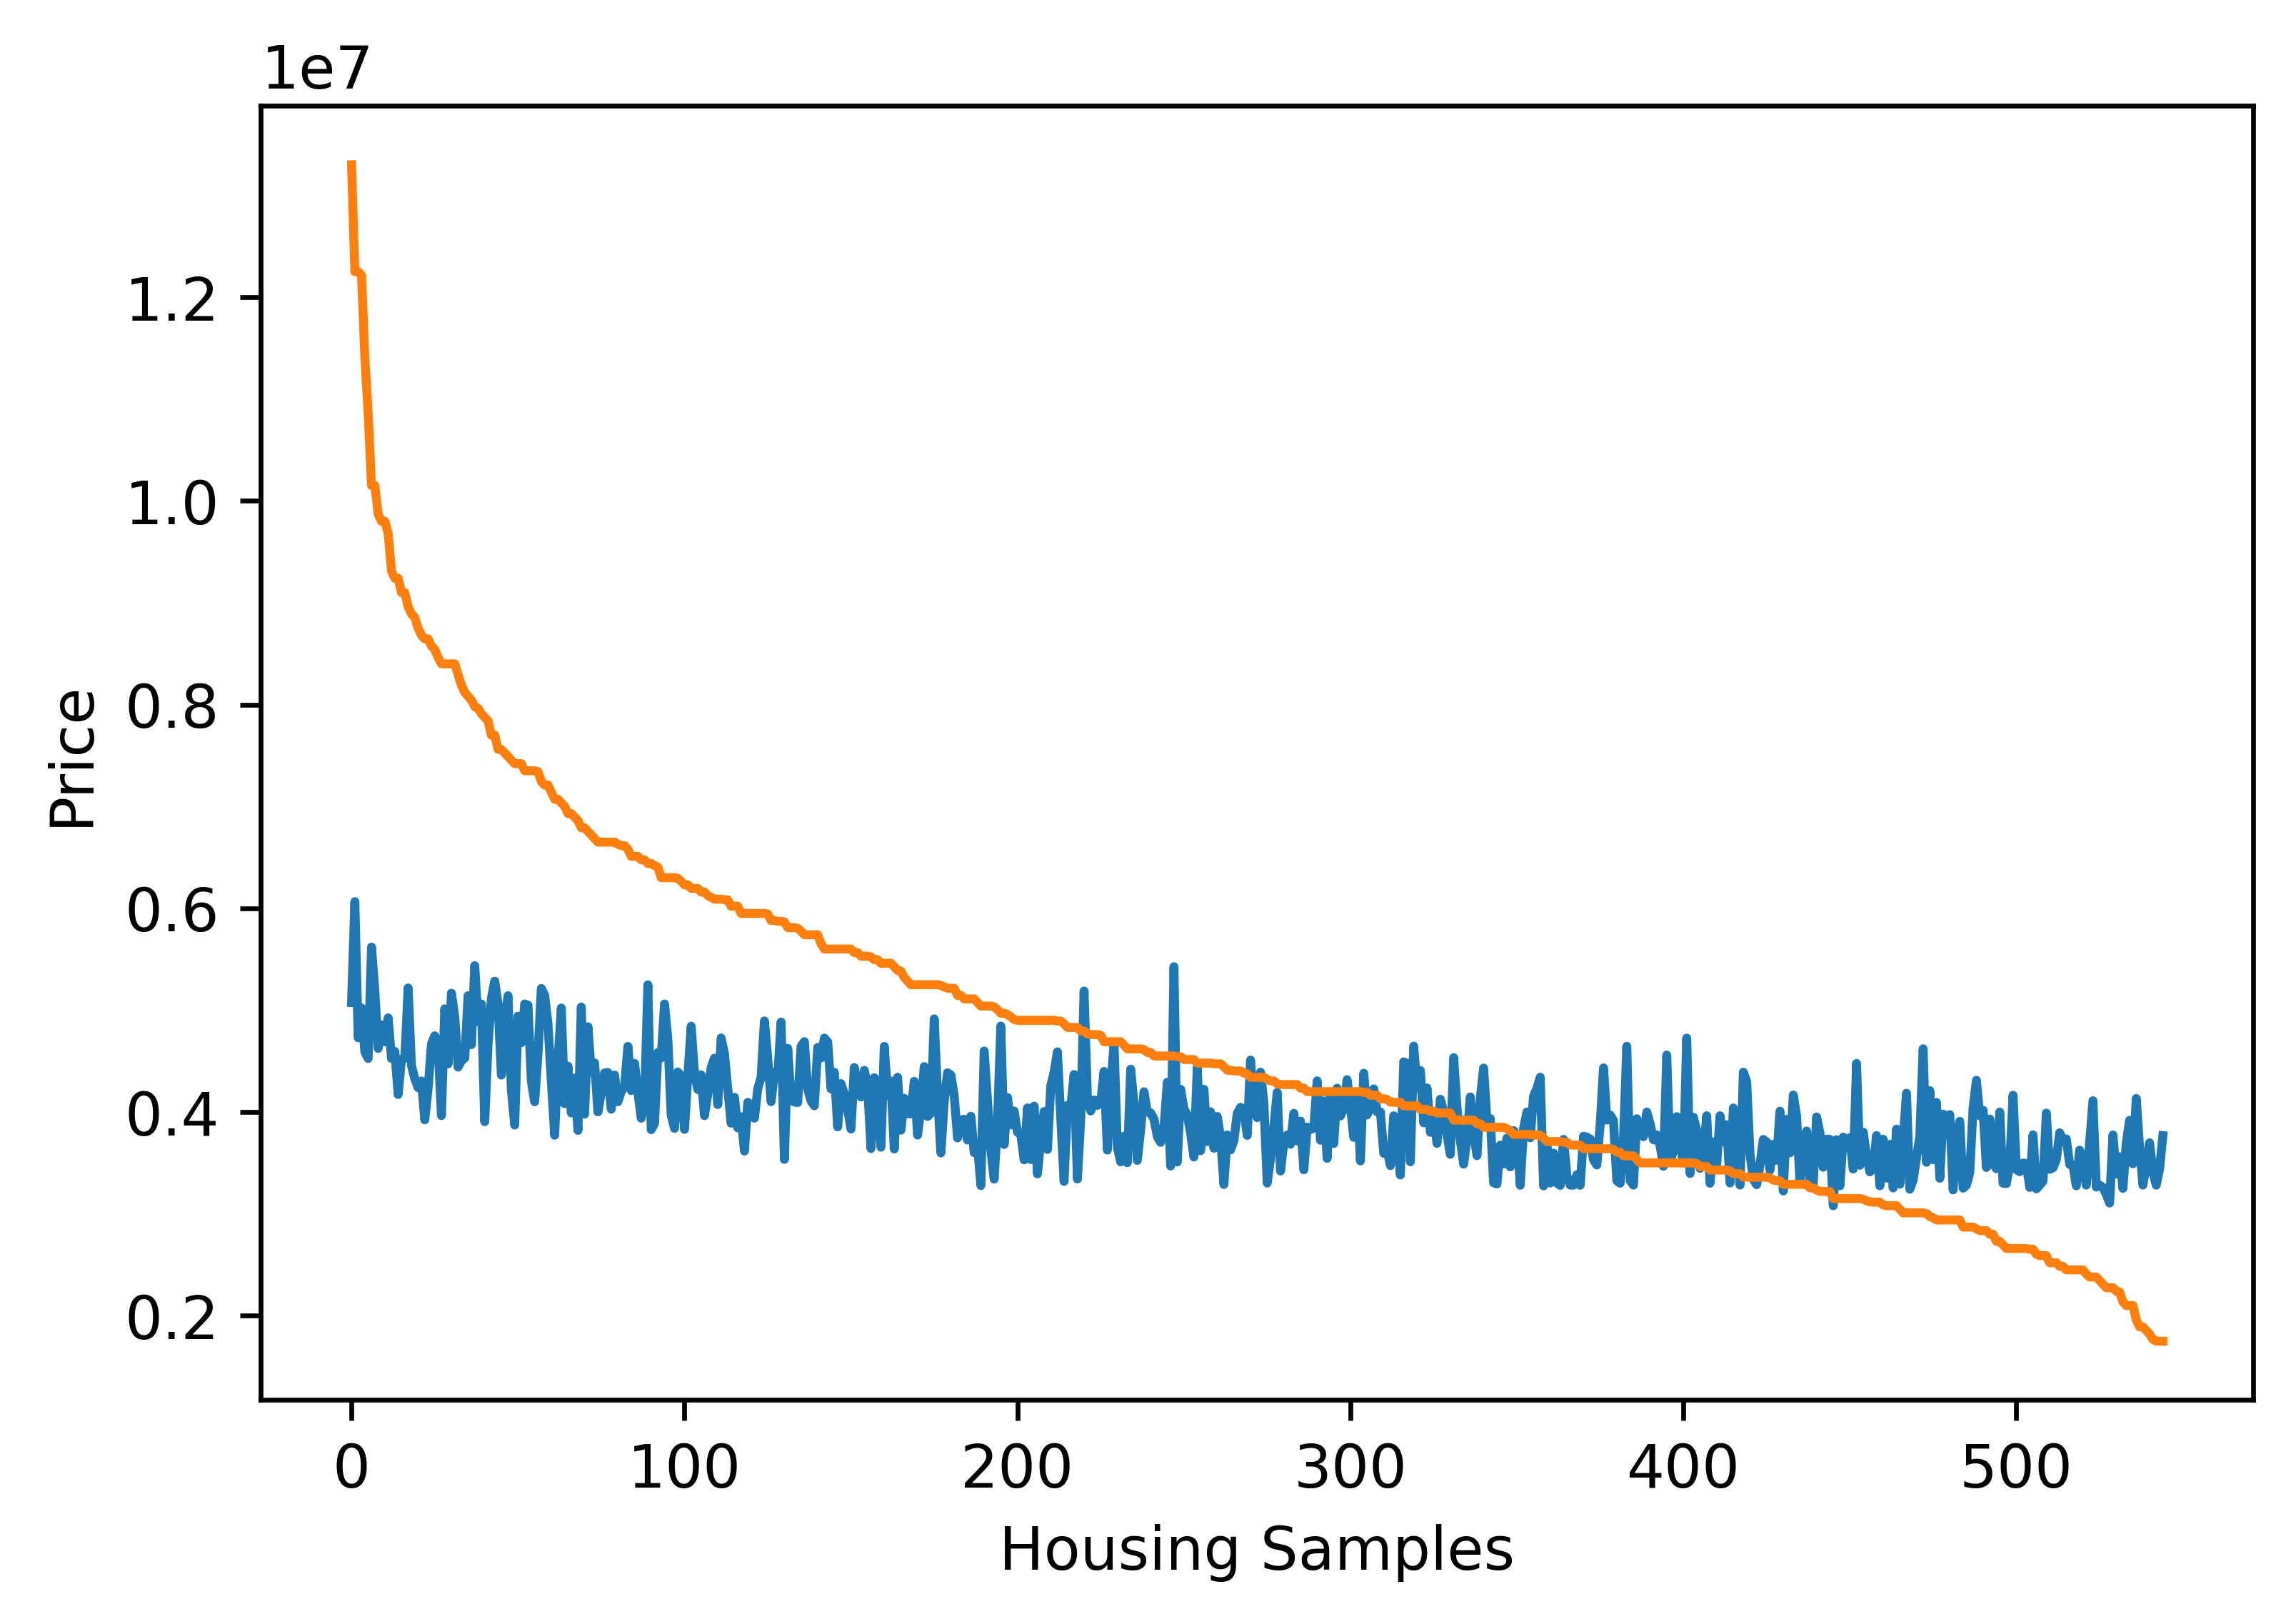

In [45]:
%matplotlib inline
#t_area, t_bedrooms, t_bathrooms, t_stories, t_parking
t_p = model(t_areaN, t_bedroomsN, t_bathroomsN, t_storiesN, t_parkingN, *params)
fig = plt.figure(dpi=600)
plt.xlabel("Housing Samples")
plt.ylabel("Price")
plt.plot(t_p.detach().numpy())
plt.plot(t_price)

Problem 3

3.a Build a fully connected neural network for the housing dataset you did in previous problem. For training and validation use 80% (training) and 20% (validation) split. For this part, only use one hidden layer with 8 nodes. Train your network for 200 epochs. Report your training time, training loss, and evaluation accuracy after 200 epochs. Analyze your results in your report. Make sure to submit your code by providing the GitHub URL of your course repository for this course. (15pts)

3.b Extend your network with two more additional hidden layers, like the example we did in lecture. Train your network for 200 epochs. Report your training time, training loss, and evaluation accuracy after 200 epochs. Analyze your results in your report. Make sure to submit your code by providing the GitHub URL of your course repository for this course. Analyze your results in your report and compare your model size and accuracy over the baseline implementation in Problem1. a. Do you see any over-fitting? Make sure to submit your code by providing the GitHub URL of your course repository for this course. (25pts)

In [46]:
housing = pd.DataFrame(pd.read_csv("/content/drive/MyDrive/ECGR 4105 - Intro to Machine Learning/Homework/Housing.csv")) 
housing.head() 

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [47]:
m = len(housing) 
m 

545

In [48]:
housing.shape 

(545, 13)

In [49]:
housing.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [50]:
housing.describe() 

,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


In [51]:
# You can see that your dataset has many columns with values as 'Yes' or 'No'. 
# But in order to fit a regression line, we would need numerical values and not string.
# List of variables to map 
 
varlist =  ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning'] 
 
# Defining the map function 
def binary_map(x): 
    return x.map({'yes': 1, "no": 0}) 
 
# Applying the function to the housing list 
housing[varlist] = housing[varlist].apply(binary_map) 
 
# Check the housing dataframe now 
housing.head() 

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,yes,furnished
1,12250000,8960,4,4,4,1,0,0,0,1,3,no,furnished
2,12250000,9960,3,2,2,1,0,1,0,0,2,yes,semi-furnished
3,12215000,7500,4,2,2,1,0,1,0,1,3,yes,furnished
4,11410000,7420,4,1,2,1,1,1,0,1,2,no,furnished


In [52]:
#Splitting the Data into Training and Testing Sets 
from sklearn.model_selection import train_test_split 
 
# We specify this so that the train and test data set always have the same rows, respec
np.random.seed(0) 
df_train, df_test = train_test_split(housing, train_size = 0.8, test_size = 0.2, random_state=42)
df_train.shape

(436, 13)

In [53]:
df_test.shape 

(109, 13)

In [54]:

num_vars = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking','price'] 
df_Newtrain = df_train[num_vars] 
df_Newtest = df_test[num_vars] 
df_Newtrain.head() 

,area,bedrooms,bathrooms,stories,parking,price
46,6000,3,2,4,1,7525000
93,7200,3,2,1,3,6300000
335,3816,2,1,1,2,3920000
412,2610,3,1,2,0,3430000
471,3750,3,1,2,0,3010000


In [55]:
df_Newtrain.shape 

(436, 6)

In [56]:
# Here we can see that except for area, all the columns have small integer values.  
#So it is extremely important to rescale the variables so that they have a comparable s
#If we don't have comparable scales, then some of the coefficients as obtained by fitti
#This might become very annoying at the time of model evaluation.  
##So it is advised to use standardization or normalization so that the units of the coef
 
#As you know, there are two common ways of rescaling:
#1. Min-Max scaling 
#2. Standardisation (mean-0, sigma-1) 
 
import warnings 
warnings.filterwarnings('ignore') 
 
from sklearn.preprocessing import MinMaxScaler, StandardScaler 
 
# define standard scaler 
#scaler = StandardScaler() 
scaler = MinMaxScaler() 
df_Newtrain[num_vars] = scaler.fit_transform(df_Newtrain[num_vars])
df_Newtest[num_vars] = scaler.fit_transform(df_Newtest[num_vars])
df_Newtrain.head(20) 

,area,bedrooms,bathrooms,stories,parking,price
46,0.298969,0.4,0.333333,1.000000,0.333333,0.550000
93,0.381443,0.4,0.333333,0.000000,1.000000,0.433333
335,0.148866,0.2,0.000000,0.000000,0.666667,0.206667
412,0.065979,0.4,0.000000,0.333333,0.000000,0.160000
471,0.144330,0.4,0.000000,0.333333,0.000000,0.120000
237,0.230928,0.4,0.000000,0.333333,0.000000,0.273333
544,0.151203,0.4,0.000000,0.333333,0.000000,0.000000
470,0.235464,0.4,0.000000,0.000000,0.000000,0.120000
511,0.105155,0.4,0.000000,0.000000,0.000000,0.073333
361,0.300344,0.4,0.000000,0.000000,0.000000,0.186667


In [57]:
y_Newtrain = df_Newtrain.pop('price') 
x_Newtrain = df_Newtrain
y_Newtest = df_Newtest.pop('price')
x_Newtest = df_Newtest

In [58]:
y_Newtrain = torch.tensor(y_Newtrain.values).float()
y_Newtrain = y_Newtrain[:,None]
x_Newtrain = torch.tensor(x_Newtrain.values).float()
y_Newtest = torch.tensor(y_Newtest.values).float()
y_Newtest = y_Newtest[:,None]
x_Newtest = torch.tensor(x_Newtest.values).float()

In [59]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,
                  t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train) # <1>
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val) # <1>
        loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward() # <2>
        optimizer.step()

        if epoch == 1 or epoch % 10 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")

In [60]:
seq_model1 = nn.Sequential(
    nn.Linear(5,8),
    nn.Tanh(),
    nn.Linear(8, 5))
seq_model1

Sequential(
  (0): Linear(in_features=5, out_features=8, bias=True)
  (1): Tanh()
  (2): Linear(in_features=8, out_features=5, bias=True)
)

In [61]:
seq_model2 = nn.Sequential(
    nn.Linear(5,8),
    nn.Tanh(),
    nn.Linear(8,4),
    nn.Tanh(),
    nn.Linear(4,2),
    nn.Tanh(),
    nn.Linear(2, 5))
seq_model2

Sequential(
  (0): Linear(in_features=5, out_features=8, bias=True)
  (1): Tanh()
  (2): Linear(in_features=8, out_features=4, bias=True)
  (3): Tanh()
  (4): Linear(in_features=4, out_features=2, bias=True)
  (5): Tanh()
  (6): Linear(in_features=2, out_features=5, bias=True)
)

In [62]:
optimizer = optim.SGD(seq_model1.parameters(), lr=1e-3)
training_loop(200, optimizer, seq_model1, nn.MSELoss(), x_Newtrain, x_Newtest, y_Newtrain, y_Newtest)

Epoch 1, Training loss 0.1973, Validation loss 0.2086
Epoch 10, Training loss 0.1943, Validation loss 0.2056
Epoch 20, Training loss 0.1910, Validation loss 0.2023
Epoch 30, Training loss 0.1878, Validation loss 0.1991
Epoch 40, Training loss 0.1847, Validation loss 0.1960
Epoch 50, Training loss 0.1816, Validation loss 0.1930
Epoch 60, Training loss 0.1787, Validation loss 0.1900
Epoch 70, Training loss 0.1757, Validation loss 0.1871
Epoch 80, Training loss 0.1729, Validation loss 0.1843
Epoch 90, Training loss 0.1701, Validation loss 0.1815
Epoch 100, Training loss 0.1674, Validation loss 0.1788
Epoch 110, Training loss 0.1647, Validation loss 0.1762
Epoch 120, Training loss 0.1621, Validation loss 0.1736
Epoch 130, Training loss 0.1595, Validation loss 0.1710
Epoch 140, Training loss 0.1570, Validation loss 0.1686
Epoch 150, Training loss 0.1546, Validation loss 0.1661
Epoch 160, Training loss 0.1522, Validation loss 0.1638
Epoch 170, Training loss 0.1499, Validation loss 0.1615
Epo

In [63]:
optimizer = optim.SGD(seq_model2.parameters(), lr=1e-3)
training_loop(200, optimizer, seq_model2, nn.MSELoss(), x_Newtrain, x_Newtest, y_Newtrain, y_Newtest)

Epoch 1, Training loss 0.0629, Validation loss 0.0730
Epoch 10, Training loss 0.0625, Validation loss 0.0726
Epoch 20, Training loss 0.0621, Validation loss 0.0722
Epoch 30, Training loss 0.0616, Validation loss 0.0717
Epoch 40, Training loss 0.0612, Validation loss 0.0713
Epoch 50, Training loss 0.0608, Validation loss 0.0709
Epoch 60, Training loss 0.0604, Validation loss 0.0705
Epoch 70, Training loss 0.0600, Validation loss 0.0701
Epoch 80, Training loss 0.0596, Validation loss 0.0697
Epoch 90, Training loss 0.0592, Validation loss 0.0693
Epoch 100, Training loss 0.0588, Validation loss 0.0690
Epoch 110, Training loss 0.0585, Validation loss 0.0686
Epoch 120, Training loss 0.0581, Validation loss 0.0682
Epoch 130, Training loss 0.0577, Validation loss 0.0678
Epoch 140, Training loss 0.0573, Validation loss 0.0675
Epoch 150, Training loss 0.0570, Validation loss 0.0671
Epoch 160, Training loss 0.0566, Validation loss 0.0668
Epoch 170, Training loss 0.0563, Validation loss 0.0664
Epo